In [44]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.signal import correlate, correlation_lags
from scipy.stats import hmean, tstd

In [45]:
def input_data(file_1, file_2):
    if file_1.__contains__('.csv'):
        df = pandas.read_csv(file_1)
    else:
        df = pandas.read_excel(file_1, sheet_name='Sheet1')

    tdf = pandas.read_excel(file_2, index_col=1, sheet_name='Data')
    tdf = tdf.rename(columns={'Pupil diameter left [mm]': 'left_r', 'Pupil diameter right [mm]': 'right_r', 
                             'Recording timestamp [ms]': 'time'})
    tdf = tdf[['time', 'left_r', 'right_r']].iloc[1:, :]
    return df, tdf

file_1 = '02_19/pupil_data_sun.csv'
file_2 = 'tobii/dark_video_tobii_sun.xlsx'
df, tdf = input_data(file_1, file_2)
video_len = 60+12 #second

# formalise the opencv data (into second)
# df = df[['time', 'left_r', 'right_r']]
s = df['time'][0]
avg_amount = (list(df['time'])[-1] - s)/video_len # calculate interval each second
df['time'] = [ ((i-s)/avg_amount)-4 for i in df['time']]#remove the first 4 seconds, fluctuaion of light in video

df = df[df['time'] >= 0]
df = df.set_index('time')

#formalise eye tracker data (into second)
tdf['time'] = [ (i/1000)-4 for i in tdf['time']] #remove the first 4 seconds, fluctuaion of light in video
tdf['left_r'] = [i/2 for i in tdf['left_r']]
tdf['right_r'] = [i/2 for i in tdf['right_r']]
tdf = tdf[tdf['time'] >= 0]
tdf = tdf.set_index('time')

In [46]:
from collections import OrderedDict
def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def eliminate_outliers(values, bias = 0.5):
    print('before', len(values))
    q1,q3 = get_quartiles(values)
    iqr = q3 - q1
    lowerLimit = q1 - bias*iqr
    upperLimit = q3 + bias*iqr
    print('lower', lowerLimit, q1, q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: result.append(np.nan)
        else:
            result.append(v)
    print('after', len([i for i in result if i is not np.nan]), '\n')
    return result

before 3984
lower 14.05 17.5 29.0 upper 32.45
after 3184 



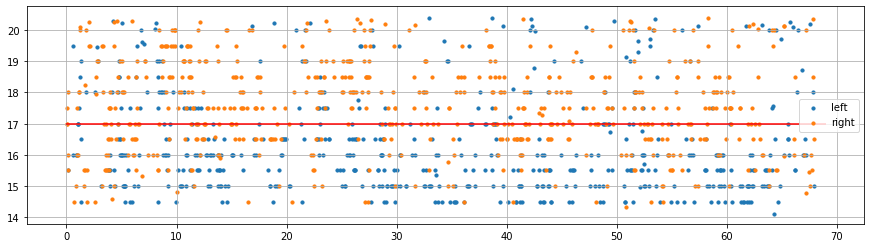

In [47]:
#remove by radius
values = np.concatenate( [list(df['left_r']), list(df['right_r'])] )
sep = len(df['left_r'])

values = eliminate_outliers(values, 0.3)
df['left_r'] = values[:sep]
df['right_r'] = values[sep:]

# #remove by x coordinate
# values = np.concatenate( [list(df['left_x']), list(df['right_x'])] )
# sep = len(df['left_x'])

# values = eliminate_outliers(values)
# df['left_x'] = values[:sep]
# df['right_x'] = values[sep:]
baseline = 17
left_r = []
right_r = []
for i, r in df.iterrows():
    if abs(r['left_r'] - baseline) > 3.4:
        left_r.append(np.nan)
    else:
        left_r.append(r['left_r'])
        
    if abs(r['right_r'] - baseline) > 3.4:
        right_r.append(np.nan)
    else:
        right_r.append(r['right_r'])
        
# for i, r in df.iterrows():
#     if np.isnan(r['left_x']):
#         left_r.append(np.nan)
#     else:
#         left_r.append(r['left_r'])
        
#     if np.isnan(r['right_x']):
#         right_r.append(np.nan)
#     else:
#         right_r.append(r['right_r'])
        
df['left_r'] = left_r
df['right_r'] = right_r

#plot left and right
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=list(df.index), y=df['left_r'], s=10, label='left')
ax.scatter(x=list(df.index), y=df['right_r'], s=10, label='right')
ax.hlines(y=baseline, xmin=0, xmax=list(df.index)[-1]+1, color='red')
ax.grid()
ax.legend(loc='best')

# print('total valid radius', len([i for i in left_r if not np.isnan(i)]) + len([i for i in right_r if not np.isnan(i)]))

## scatter plot of radius of eye_tracker

before 8296
lower 0.9324999999999999 0.985 1.06 upper 1.1125
after 7518 



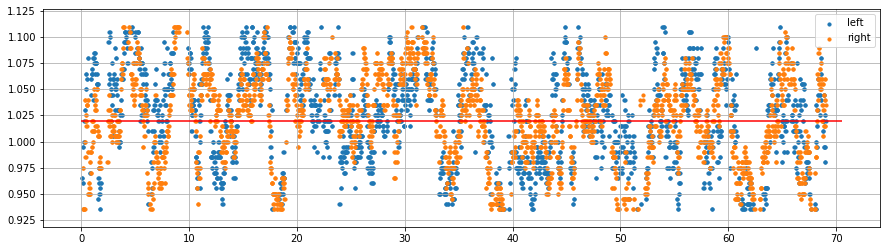

In [48]:
values = np.concatenate( [list(tdf['left_r']), list(tdf['right_r'])] )
sep = len(tdf['left_r'])

values = eliminate_outliers(values, 0.7)
tdf['left_r'] = values[:sep]
tdf['right_r'] = values[sep:]

t_baseline = 1.02
left_r = []
right_r = []
for i, r in tdf.iterrows():
    if abs(r['left_r'] - t_baseline) > 0.23:
        left_r.append(np.nan)
    else:
        left_r.append(r['left_r'])
        
    if abs(r['right_r'] - t_baseline) > 0.23:
        right_r.append(np.nan)
    else:
        right_r.append(r['right_r'])
               
tdf['left_r'] = left_r
tdf['right_r'] = right_r

#plot left and right
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=list(tdf.index), y=tdf['left_r'], s=10, label='left')
ax.scatter(x=list(tdf.index), y=tdf['right_r'], s=10, label='right')
ax.hlines(y=t_baseline, xmin=0, xmax=list(tdf.index)[-1]+1, color='red')
ax.grid()
ax.legend(loc='best')

In [49]:
#merge left and right
def merge_both_side(df):
    result = []
    for i, r in df.iterrows():
        a = r['left_r']
        b = r['right_r']

        if not np.isnan(a) and not np.isnan(b):
            result.append(hmean((a, b)))
        elif not np.isnan(a):
            result.append(a)
        elif not np.isnan(b):
            result.append(b)
        else:
            result.append(np.nan)
    df['pupil'] = result
    df = df.drop(labels=['left_r', 'right_r'], axis=1)
    return df

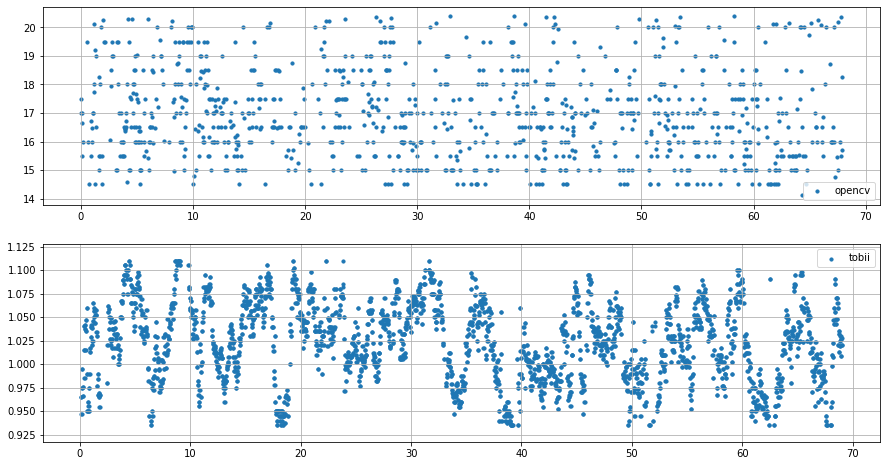

In [50]:
merge_df = merge_both_side(df)
merge_tdf = merge_both_side(tdf)

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

ax1.scatter(x=list(merge_df.index), y=merge_df['pupil'], s=10, label='opencv')
ax2.scatter(x=list(merge_tdf.index), y=merge_tdf['pupil'], s=10, label='tobii')

ax1.grid()
ax1.legend(loc='best')
ax2.grid()
ax2.legend(loc='best')

In [51]:
def normalise(df):
    result = {}
    values = []
    current_sec = 0
    for i, r in df.iterrows():
        if i <= current_sec:
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
        else:
            if len(values) == 0:
                if current_sec > 0.5:
                    result.update({current_sec: result[current_sec-1]}) #if no available value, then select the last one
                else:
                    result.update({current_sec: np.nan})
            else:
#                 values = sorted(values)
#                 if len(values) >= 4:
#                     values = values[1:-2] #remove the biggest and smallest
                result.update({current_sec: hmean(values)})
                values = []
                
            current_sec += 0.5
            if r['pupil'] != 0 and not np.isnan(r['pupil']):
                values.append(r['pupil'])
    
    #for the last sec
    result.update({current_sec: hmean(values)})
    result = pandas.DataFrame.from_dict(result, orient='index', columns=['radius'])
    result['pcps'] = result['radius'].pct_change()
    result['pcps'][0] = 0
    return result

In [66]:
from dtw import *

def cal_rate(ary, baseline=None): #pupil change rate
    result = []
    if baseline is None:
        for a, b in zip(ary[:-2], ary[1:]):
            result.append( (b-a)/a )
    else:
        for a in ary:
            result.append( (a-baseline)/baseline)
    return result

def plot_rate(ary1, ary2, timeframe, overlap):
    query = ary1
    template = ary2
    ### plot
    ary1 = np.square(ary1)
    ary2 = np.square(ary2)
    
    total = 0 #total matching
    for i in range(min(len(ary2), len(ary1))-1):
        if ary1[i] >= ary1[i+1] and ary2[i] >= ary2[i+1]: total += 1
        elif ary1[i] <= ary1[i+1] and ary2[i] <= ary2[i+1]: total += 1

    print('total matching ', total, min(len(ary1)-1, len(ary2)-1), np.around(total/ min(len(ary1)-1, len(ary2)-1), decimals=3))
    print('\nEye_Tracker Mean:', np.around(np.mean(ary1), decimals=3), 'SD:', np.around(tstd(ary1), decimals=3))
    print('Opencv Mean:', np.around(np.mean(ary2), decimals=3), 'SD:', np.around(tstd(ary2), decimals=3), '\n')
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))
    ax1.plot(ary1, label='eye_tracker')
    ax1.plot(ary2, label='opencv software')

    ax1.scatter(x=np.arange(len(ary1)), y=ary1, s=10, color='red')
    ax1.scatter(x=np.arange(len(ary2)), y=ary2, s=10, color='red')

    ax1.set_xlabel('time(per '+ str(timeframe) +' second)')
    ax1.set_ylabel('percentage changes in pupil size')
    ax1.grid()
    ax1.legend(loc='best')
    
    corr = correlate(ary1, ary2)
    lags = correlation_lags(len(ary1), len(ary2))
    corr /= np.max(corr)
    ax2.plot(lags, corr, label='cross-correlated signals')
    ax2.grid()
    ax1.set_title('percentage changes in pupil size line charts (' + str(timeframe) + 'sec timeframe with ' + str(overlap) + ')')
    ax2.set_title('cross-correlation lag')
    print('The cross-correlation score is: ', np.around(sum(corr), decimals=3))
    
    import scipy.stats as stats       
    r, p = stats.pearsonr(np.arange(len(ary1)), ary1)
    print('pearson correlation of eye_tracker (r, p):', np.around(r, decimals=3), np.around(p, decimals=3))

    r, p = stats.pearsonr(np.arange(len(ary2)), ary2)
    print('pearson correlation of opencv software (r, p):', np.around(r, decimals=3), np.around(p, decimals=3))
    
    plt.tight_layout()
    plt.savefig('02_25/sun_' + str(timeframe) + '_plot.png', dpi=50)
    

    ## Find the best match with the canonical recursion formula
    alignment = dtw(ary1, ary2, keep_internals=True)
    print('\nDTW min distance /normalised', np.around(alignment.distance,decimals=3), np.around(alignment.normalizedDistance, decimals=3) )
    alignment = alignment.plot(type="threeway")

    ## Display the warping curve, i.e. the alignment curve
    alignment.set_xlabel(str(timeframe) +' second)')
    alignment.figure.savefig('02_25/sun_' + str(timeframe) + '_dtw.png', dpi=50)
    
    ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
    a = dtw(ary1, ary2, keep_internals=True, 
        step_pattern=rabinerJuangStepPattern(6, "c"))\
        .plot(type="twoway",offset=-2)
    
    a.set_xlabel(str(timeframe) +' second)')
    a.figure.savefig('02_25/sun_' + str(timeframe) + '_dtw_align.png', dpi=50)
    
    ## See the recursion relation, as formula and diagram
    print(rabinerJuangStepPattern(6,"c"))
    rabinerJuangStepPattern(6,"c").plot()
    

In [53]:
def normalise_sec(df, sec=2, overlap=1, half=False): #input dict, half: if overlap has 0.5 sec
    df = pandas.DataFrame.to_dict(df)['radius']
    result = {}
#     print(int(list(df.keys())[-1]))
    end = int(list(df.keys())[-1])-sec-overlap       
    interval = sec-overlap
    if half:
        interval = sec
        end -= 0.5
        end = int(end)
    
    current = 0
    values = []
    while (current <= end):
        # get the value for each 0.5 second
        seconds = np.arange(current, current+sec, 0.5)
        for a in seconds:
            if a <= list(df.keys())[-1]:
                n = df[a]
                if not np.isnan(n):
                    values.append(n)
                
        # update result
        if len(values) == 0 and current != 0:
            result.update({current: result[i-1]})
        else:
            result.update({current: hmean(values)})
            values = []
            
        current += sec
        current -= overlap
        
    if np.isnan(result[0]):
        result.update({0: result[1]})
    
    result = pandas.DataFrame.from_dict(result, orient='index', columns=['radius'])
    result['pcps'] = result['radius'].pct_change()
    result['pcps'][0] = 0
    return result

In [54]:
def normalise_rate_sec(ary, sec=2, overlap=1, half=False): #input dict, half: if overlap has 0.5 sec
    result = []
    end = len(ary)-sec-overlap       
    interval = sec-overlap
    if half:
        interval = sec
        end -= 0.5
        end = int(end)
    
    current = 0
    values = []
    while (current <= end):
        # get the value for each 1 second
        seconds = np.arange(current, current+sec, 1)
        for a in seconds:
            if a <= len(ary):
                n = ary[a]
                if not np.isnan(n):
                    values.append(n)
                
        # update result
#         print(values)
        if len(values) == 0:
            result.append(result[i-1])
        else:
            result.append(np.mean(values))
            values = []
            
        current += sec
        current -= overlap
                
    return result

In [55]:
opencv = normalise(merge_df)
tobii = normalise(merge_tdf)

ValueError: x and y must be the same size

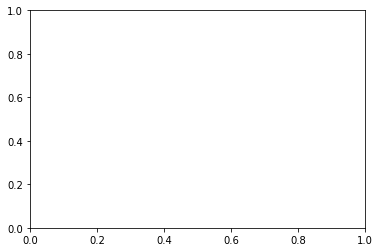

In [56]:
plt.scatter(opencv['pcps'], tobii['pcps'])

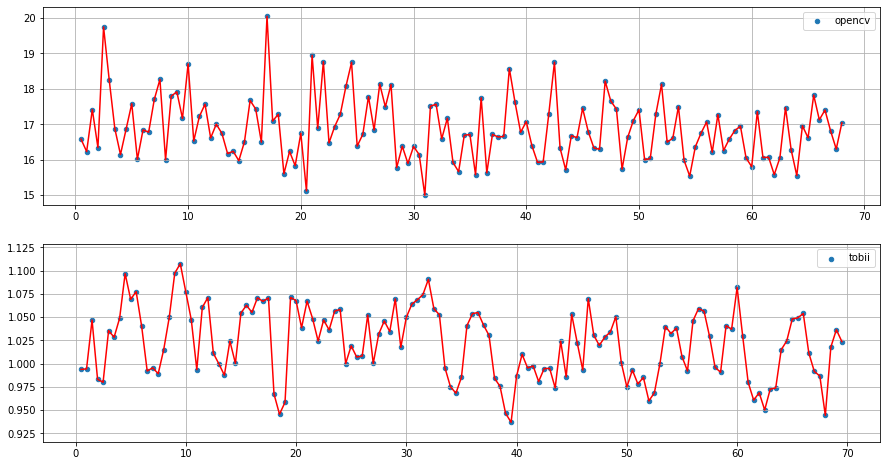

In [57]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

ax1.scatter(x=list(opencv.index), y=list(opencv['radius']), s=20, label='opencv')
ax2.scatter(x=list(tobii.index), y=list(tobii['radius']), s=20, label='tobii')
ax1.plot(list(opencv.index), list(opencv['radius']), color='red')
ax2.plot(list(tobii.index), list(tobii['radius']), color='red')

ax1.grid()
ax1.legend(loc='best')
ax2.grid()
ax2.legend(loc='best')

## 1 second timeframe

[CHECK] df total  67  values for  67  second
[CHECK] tdf total  69  values for  69  second
total matching  31 67 0.463

Eye_Tracker Mean: 0.001 SD: 0.002
Opencv Mean: 0.001 SD: 0.001 

The cross-correlation score is:  51.019
pearson correlation of eye_tracker (r, p): -0.042 0.734
pearson correlation of opencv software (r, p): -0.074 0.543

DTW min distance /normalised 0.067 0.0


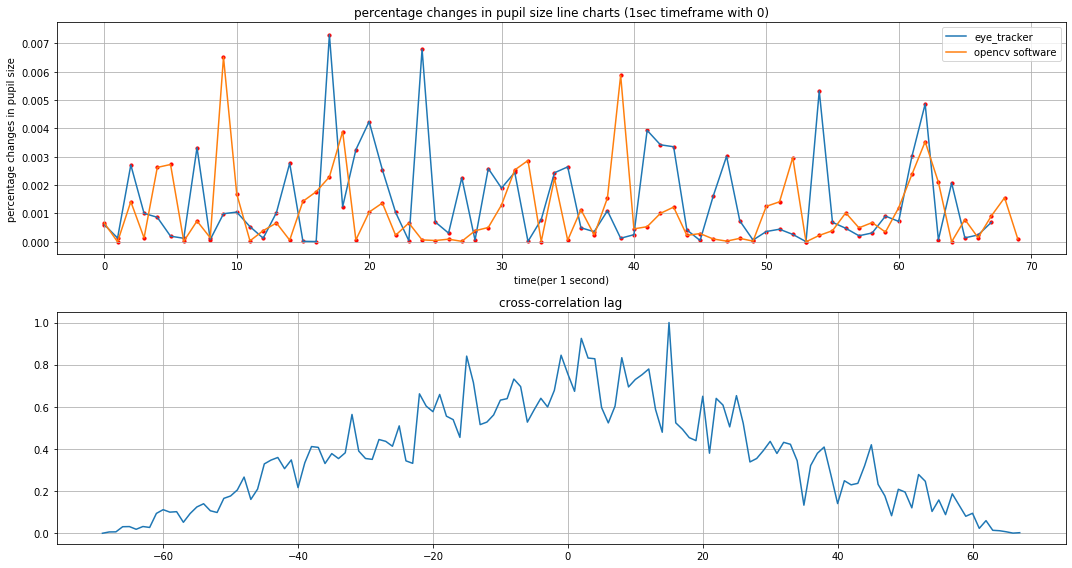

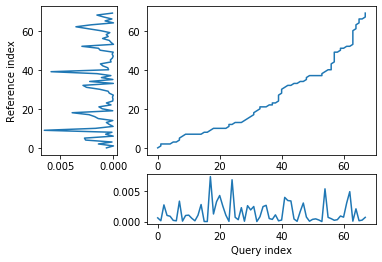

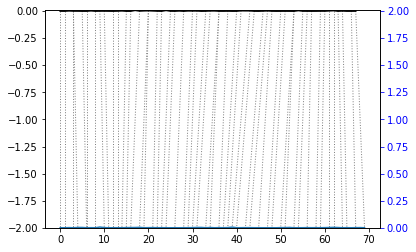

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



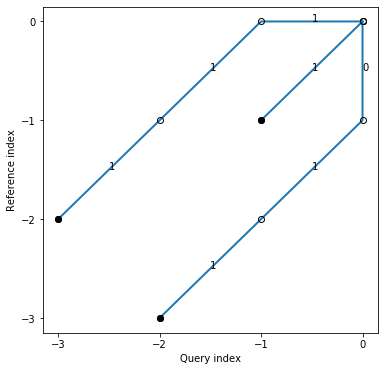

In [65]:
#normalise into 1 second timeframe
timeframe = 1
overlap = 0
df_1 = normalise_sec(opencv, timeframe, overlap)
tdf_1 = normalise_sec(tobii, timeframe, overlap)
print('[CHECK] df total ', len(df_1.index)-1, ' values for ', list(df_1.index)[-1], ' second')
print('[CHECK] tdf total ', len(tdf_1.index)-1, ' values for ', list(tdf_1.index)[-1], ' second')
py_rate_1 = cal_rate(list(df_1['radius']), baseline)
tb_rate_1 = cal_rate(list(tdf_1['radius']), t_baseline)
plot_rate(py_rate_1, tb_rate_1, 1, 0)

## 2 second timeframe (1sec overlap)

total matching  34 65 0.523

Eye_Tracker Mean: 0.001 SD: 0.001
Opencv Mean: 0.001 SD: 0.001 

The cross-correlation score is:  57.025
pearson correlation of eye_tracker (r, p): -0.039 0.749
pearson correlation of opencv software (r, p): 0.04 0.748

DTW min distance /normalised 0.04 0.0


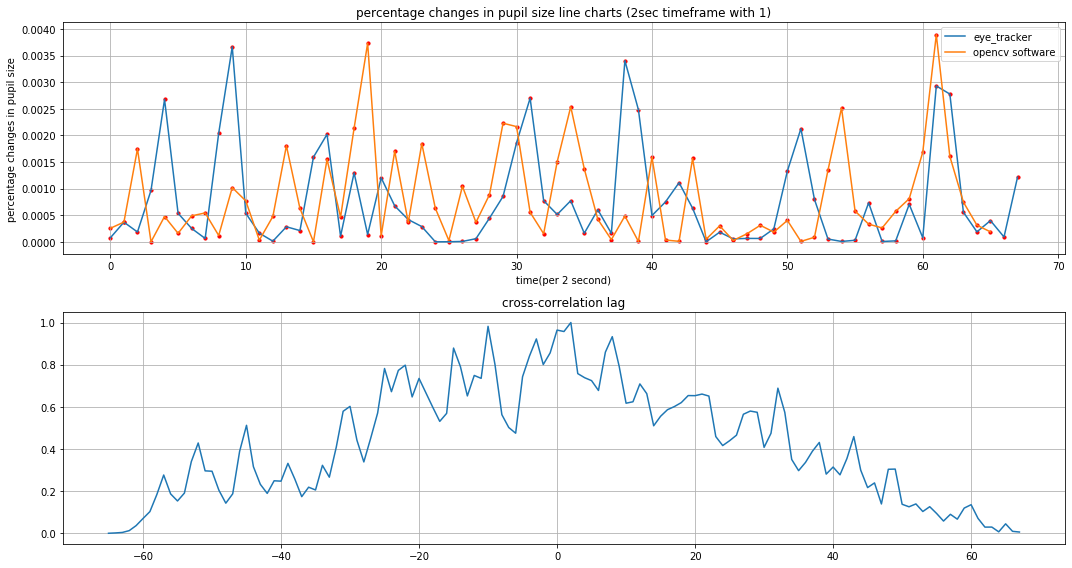

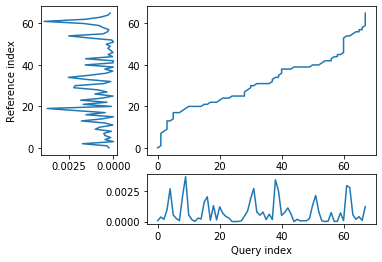

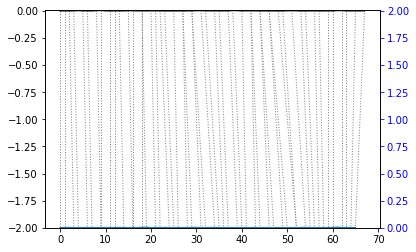

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



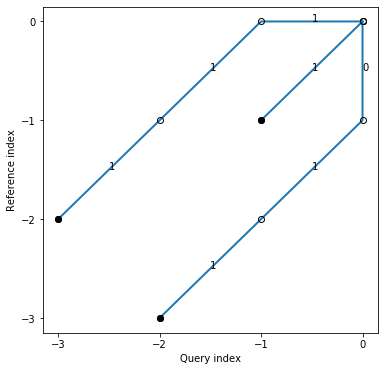

In [59]:
#normalise into 2 second timeframe
timeframe = 2
overlap = 1
df_2 = normalise_sec(opencv, timeframe, overlap)
tdf_2 = normalise_sec(tobii, timeframe, overlap)
py_rate_2 = cal_rate(list(df_2['radius']), baseline)
tb_rate_2 = cal_rate(list(tdf_2['radius']), t_baseline)
plot_rate(tb_rate_2, py_rate_2, timeframe, overlap)

## 3 second timeframe (1.5sec overlap)

total matching  20 42 0.476

Eye_Tracker Mean: 0.001 SD: 0.001
Opencv Mean: 0.001 SD: 0.001 

The cross-correlation score is:  30.683
pearson correlation of eye_tracker (r, p): 0.153 0.329
pearson correlation of opencv software (r, p): -0.068 0.663

DTW min distance /normalised 0.022 0.0


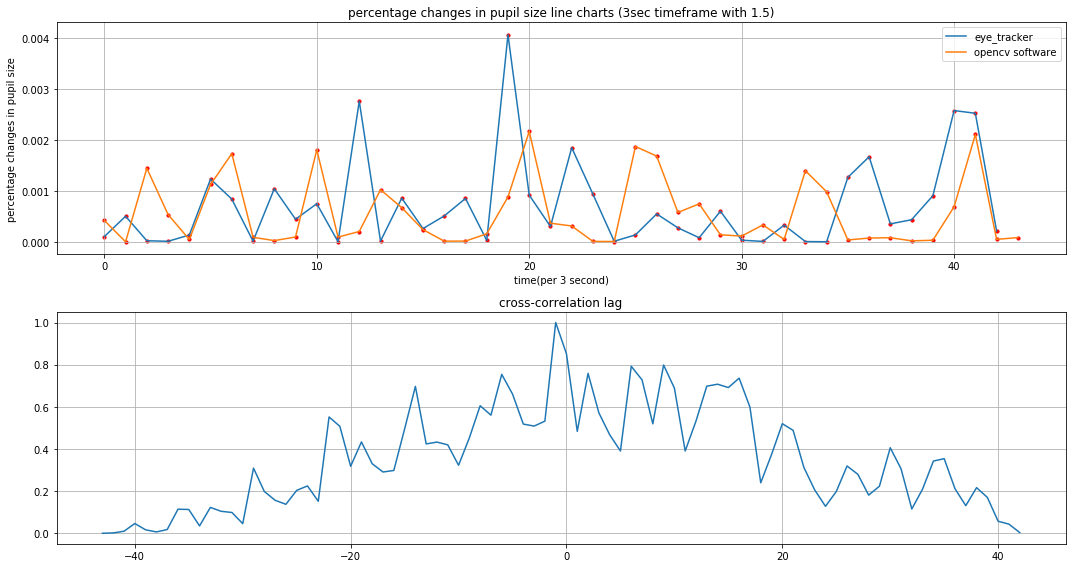

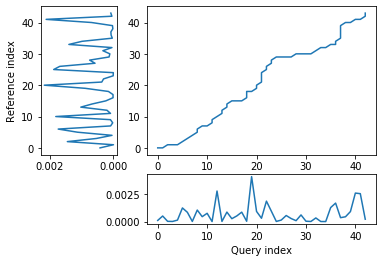

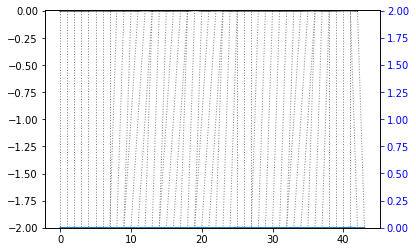

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



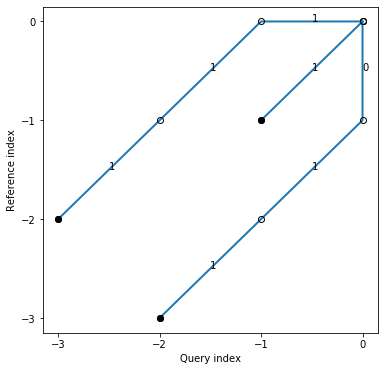

In [61]:
#normalise into 3 second timeframe
timeframe = 3
overlap = 1.5
df_3 = normalise_sec(opencv, timeframe, overlap, True)
tdf_3 = normalise_sec(tobii, timeframe, overlap, True)
py_rate_3 = cal_rate(list(df_3['radius']), baseline)
tb_rate_3 = cal_rate(list(tdf_3['radius']), t_baseline)
plot_rate(py_rate_3, tb_rate_3, timeframe, overlap)

## 5 second timeframe (1.5sec overlap)

total matching  10 17 0.588

Eye_Tracker Mean: 0.0 SD: 0.001
Opencv Mean: 0.0 SD: 0.0 

The cross-correlation score is:  10.922
pearson correlation of eye_tracker (r, p): 0.347 0.158
pearson correlation of opencv software (r, p): 0.146 0.55

DTW min distance /normalised 0.008 0.0


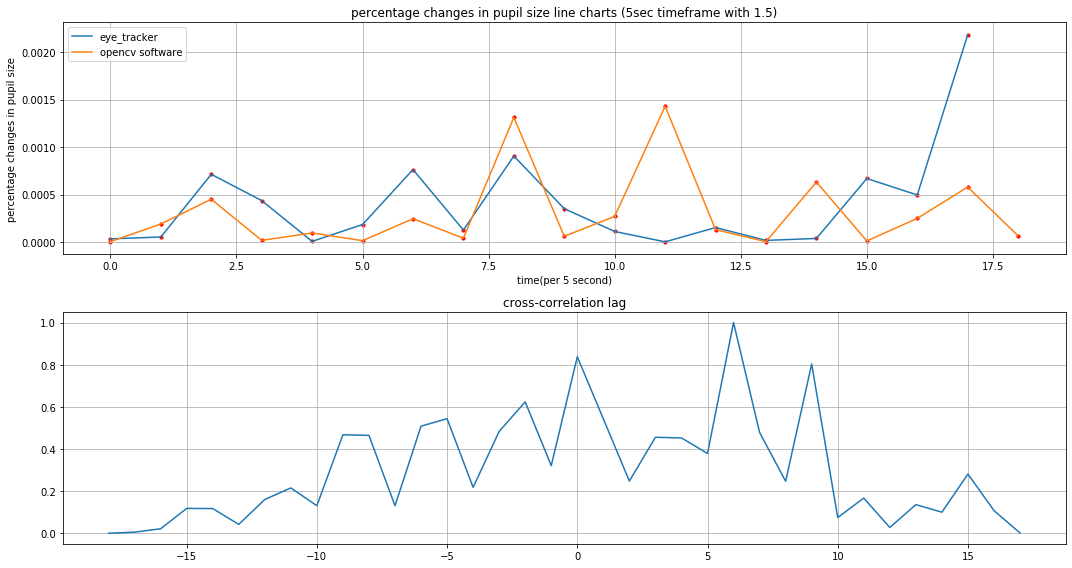

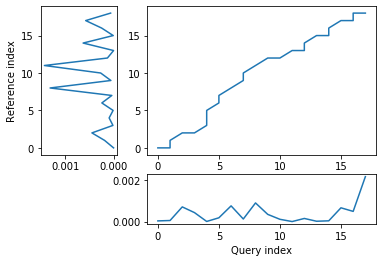

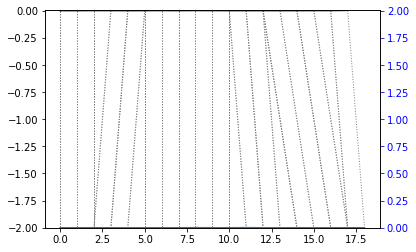

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



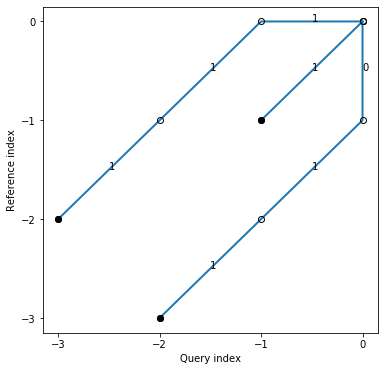

In [62]:
timeframe = 5
overlap = 1.5
df_5 = normalise_sec(opencv, timeframe, overlap, True)
tdf_5 = normalise_sec(tobii, timeframe, overlap, True)
py_rate_5 = cal_rate(list(df_5['radius']), baseline)
tb_rate_5 = cal_rate(list(tdf_5['radius']), t_baseline)
plot_rate(py_rate_5, tb_rate_5, timeframe, overlap)

## 8 second timeframe (2sec overlap)

total matching  4 9 0.444

Eye_Tracker Mean: 0.0 SD: 0.0
Opencv Mean: 0.0 SD: 0.0 

The cross-correlation score is:  6.327
pearson correlation of eye_tracker (r, p): 0.527 0.117
pearson correlation of opencv software (r, p): 0.26 0.441

DTW min distance /normalised 0.003 0.0


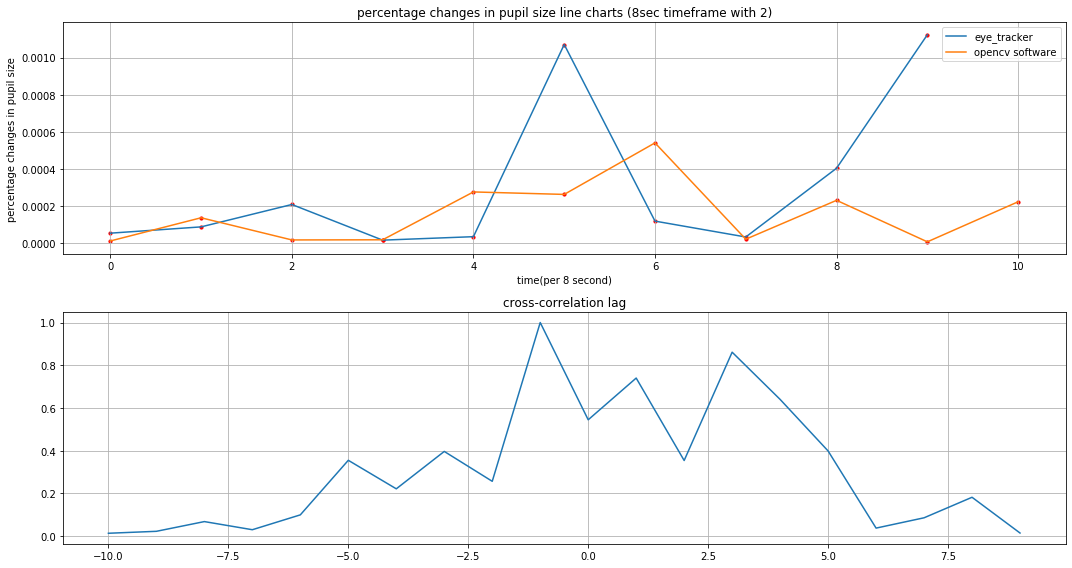

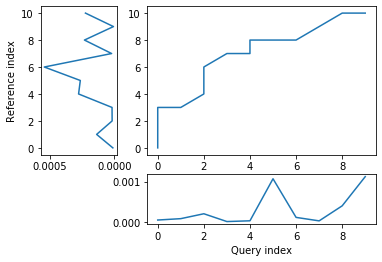

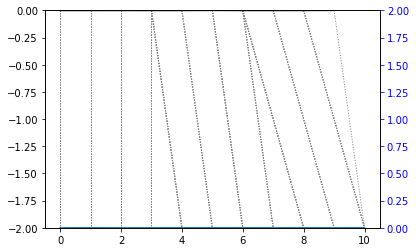

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



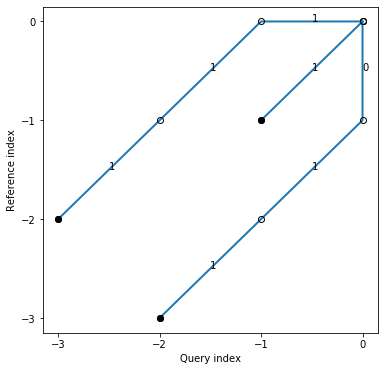

In [63]:
timeframe = 8
overlap = 2
df_8 = normalise_sec(opencv, timeframe, overlap)
tdf_8 = normalise_sec(tobii, timeframe, overlap)
py_rate_8 = cal_rate(list(df_8['radius']), baseline)
tb_rate_8 = cal_rate(list(tdf_8['radius']), t_baseline)
plot_rate(py_rate_8, tb_rate_8, timeframe, overlap)

### No baseline

total matching  29 67 0.433

Eye_Tracker Mean: 0.002 SD: 0.004
Opencv Mean: 0.001 SD: 0.002 

The cross-correlation score is:  43.957
pearson correlation of eye_tracker (r, p): -0.041 0.739
pearson correlation of opencv software (r, p): -0.046 0.704

DTW min distance /normalised 0.133 0.001


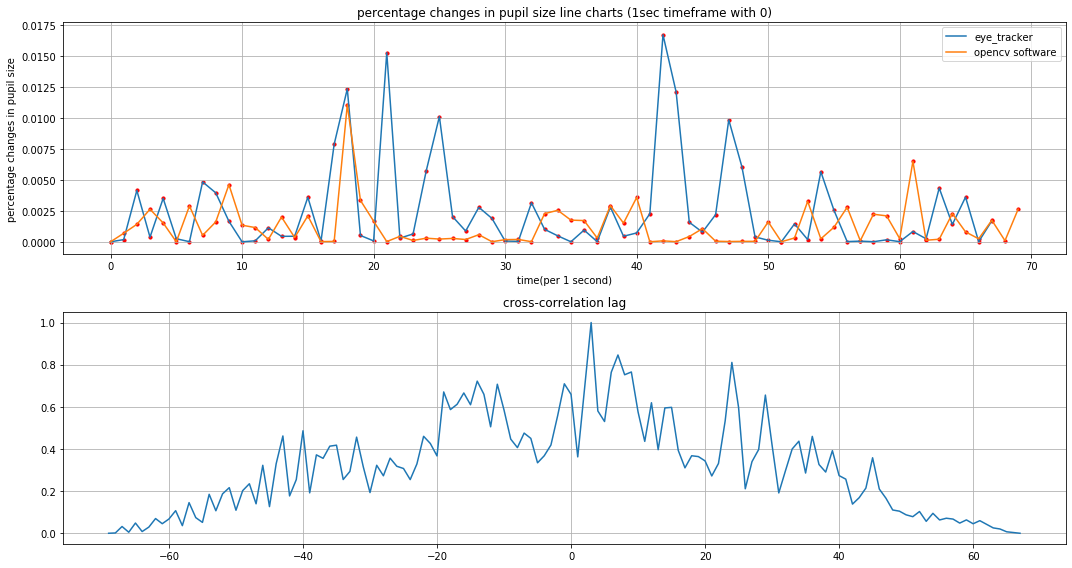

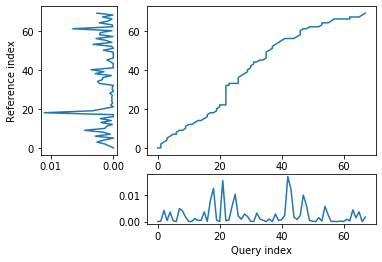

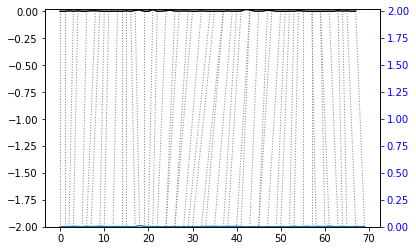

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



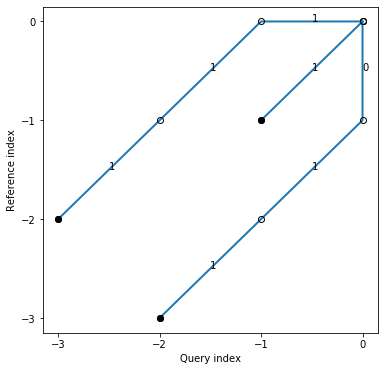

In [67]:
#normalise into 1 second timeframe
timeframe = 1
overlap = 0
df_1 = normalise_sec(opencv, timeframe, overlap)
tdf_1 = normalise_sec(tobii, timeframe, overlap)
plot_rate(df_1['pcps'], tdf_1['pcps'], timeframe, overlap)

total matching  27 65 0.415

Eye_Tracker Mean: 0.001 SD: 0.001
Opencv Mean: 0.001 SD: 0.001 

The cross-correlation score is:  49.325
pearson correlation of eye_tracker (r, p): -0.187 0.133
pearson correlation of opencv software (r, p): -0.046 0.71

DTW min distance /normalised 0.033 0.0


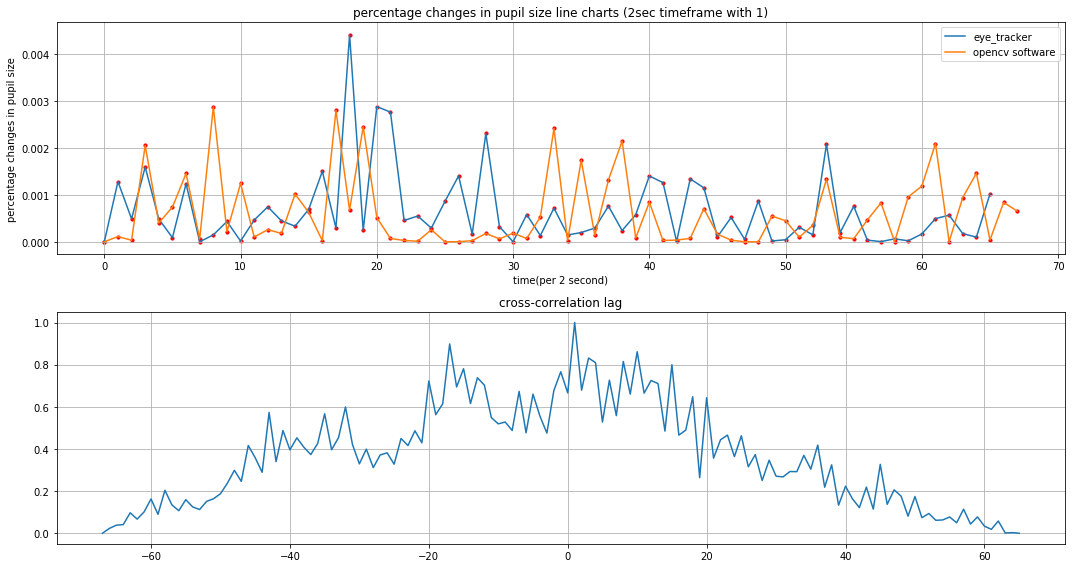

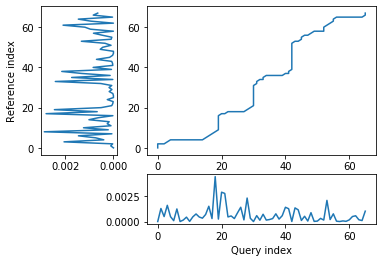

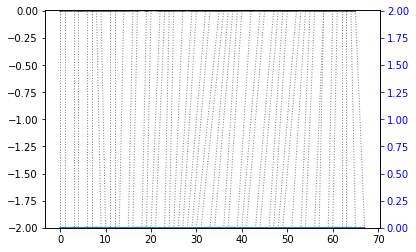

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



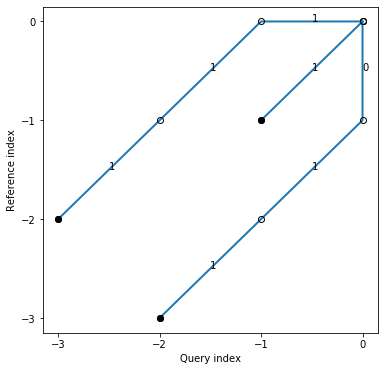

In [68]:
#normalise into 2 second timeframe
timeframe = 2
overlap = 1
df_2 = normalise_sec(opencv, timeframe, overlap)
tdf_2 = normalise_sec(tobii, timeframe, overlap)
plot_rate(list(df_2['pcps']), list(tdf_2['pcps']), timeframe, overlap)

total matching  14 32 0.438

Eye_Tracker Mean: 0.001 SD: 0.001
Opencv Mean: 0.001 SD: 0.001 

The cross-correlation score is:  26.845
pearson correlation of eye_tracker (r, p): -0.213 0.234
pearson correlation of opencv software (r, p): 0.001 0.994

DTW min distance /normalised 0.023 0.0


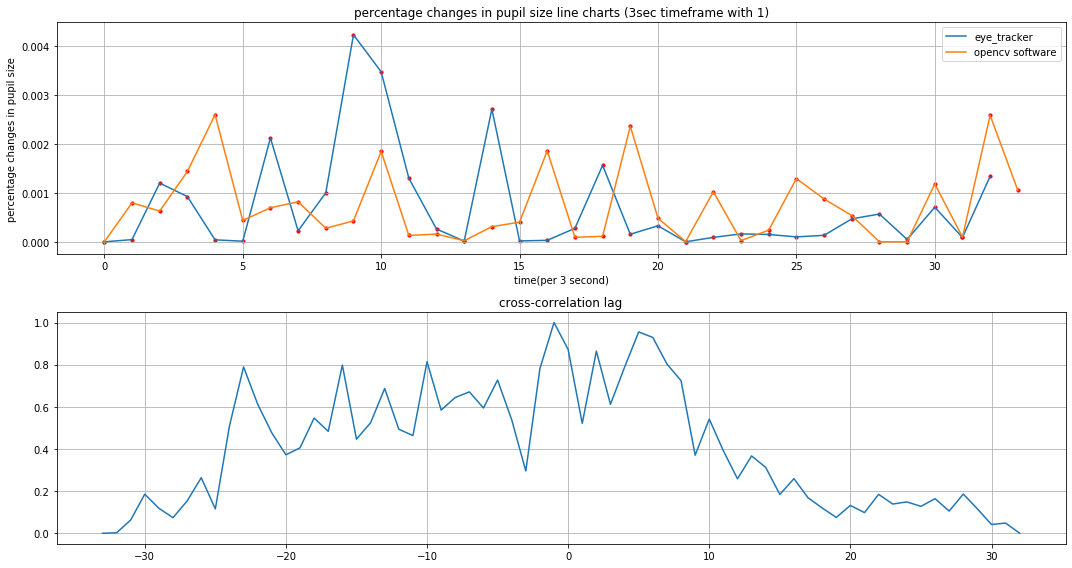

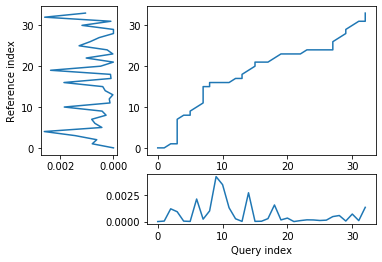

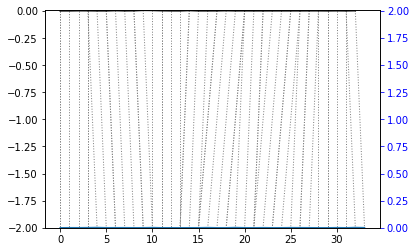

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



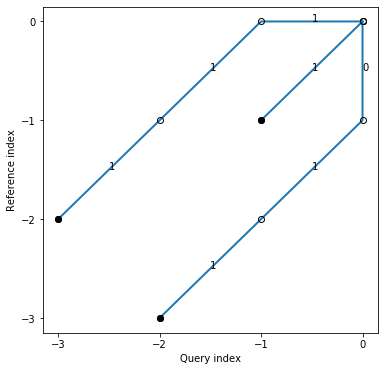

In [69]:
timeframe = 3
overlap = 1
df_3 = normalise_sec(opencv, timeframe, overlap)
tdf_3 = normalise_sec(tobii, timeframe, overlap)
plot_rate(list(df_3['pcps']), list(tdf_3['pcps']), timeframe, overlap)

total matching  13 17 0.765

Eye_Tracker Mean: 0.001 SD: 0.001
Opencv Mean: 0.0 SD: 0.0 

The cross-correlation score is:  11.239
pearson correlation of eye_tracker (r, p): -0.303 0.221
pearson correlation of opencv software (r, p): 0.577 0.01

DTW min distance /normalised 0.009 0.0


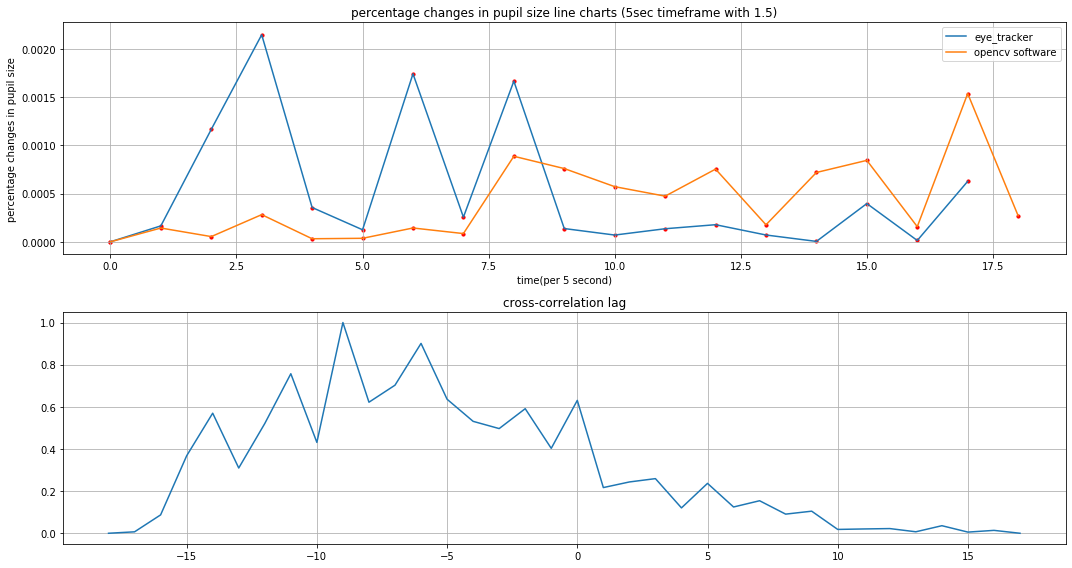

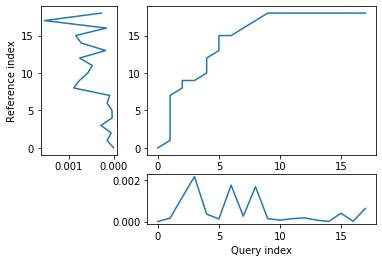

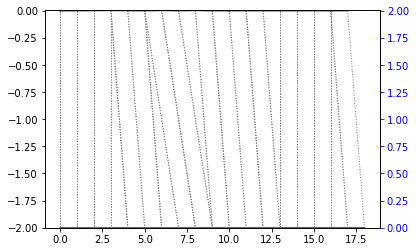

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



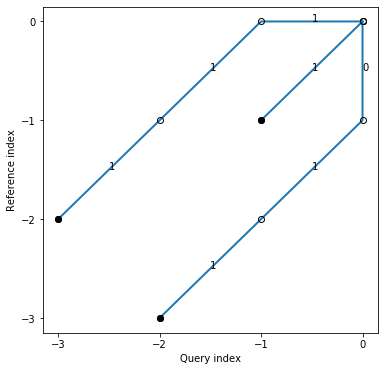

In [70]:
timeframe = 5
overlap = 1.5
df_5 = normalise_sec(opencv, timeframe, overlap)
tdf_5 = normalise_sec(tobii, timeframe, overlap)
plot_rate(list(df_5['pcps']), list(tdf_5['pcps']), timeframe, overlap)

total matching  3 9 0.333

Eye_Tracker Mean: 0.0 SD: 0.0
Opencv Mean: 0.0 SD: 0.0 

The cross-correlation score is:  4.73
pearson correlation of eye_tracker (r, p): 0.164 0.65
pearson correlation of opencv software (r, p): 0.335 0.314

DTW min distance /normalised 0.003 0.0


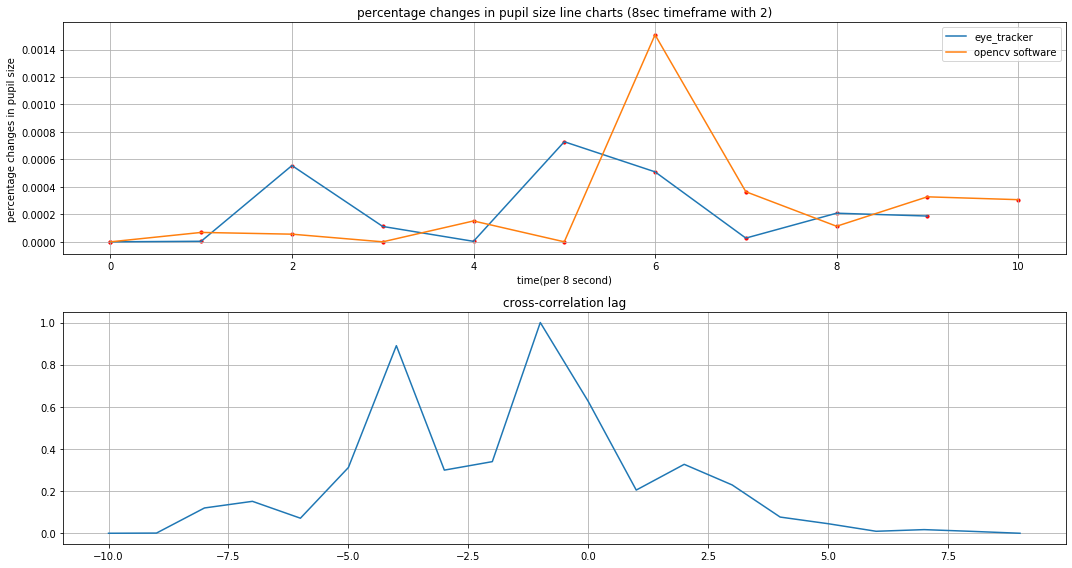

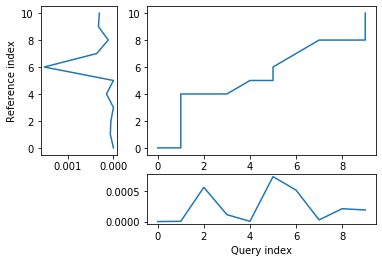

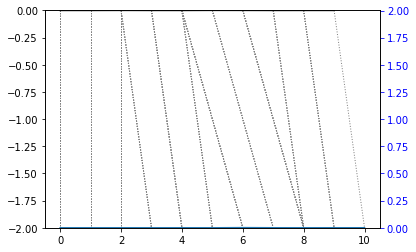

Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



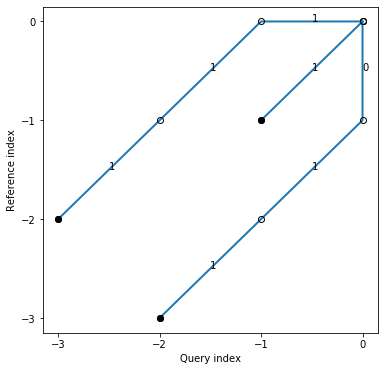

In [71]:
timeframe = 8
overlap = 2
df_5 = normalise_sec(opencv, timeframe, overlap)
tdf_5 = normalise_sec(tobii, timeframe, overlap)
plot_rate(list(df_5['pcps']), list(tdf_5['pcps']), timeframe, overlap)